# 🛡️ Fiduciary Agent: The Risk-Aware Orchestrator

## 1. The Pitch
**The Problem:**
Most AI agents are "Yes-Men", they prioritise politeness over business rules. In e-commerce, an agent that approves every refund request can bankrupt a company. Simple chatbots lack the context to distinguish between a VIP customer and a fraudulent claim.

**The Solution:**
The **Fiduciary Agent**. This is not a chatbot; it is an **Authorised RPA Controller**. It acts with "Fiduciary Responsibility," calculating **Customer Lifetime Value (CLV)** and assessing risk *before* executing any financial transaction. It empowers `Gemini-Flash-Lite` to say "No" when necessary, protecting the enterprise bottom line.

## 2. Architecture: Brain, Hands, & Memory
The system moves beyond simple conversation to a strict **"Check-then-Act" Protocol**:

* **🧠 The Brain (Gemini 2.5 Flash Lite):** Acts as the "Controller." It does not make up answers; it strictly follows a sequence to invoke the correct tools.
* **🦾 The Hands (Custom Tools):** Python-based governance layer. The business logic (Math, Risk Ratios, Bank Balances) is hidden here. The tool *physically blocks* the agent from processing risky refunds.
* **💾 The Memory (Session Service):** Maintains the user's identity (`judge_01`) and context across turns, allowing the agent to handle multiple requests in a single session without amnesia.


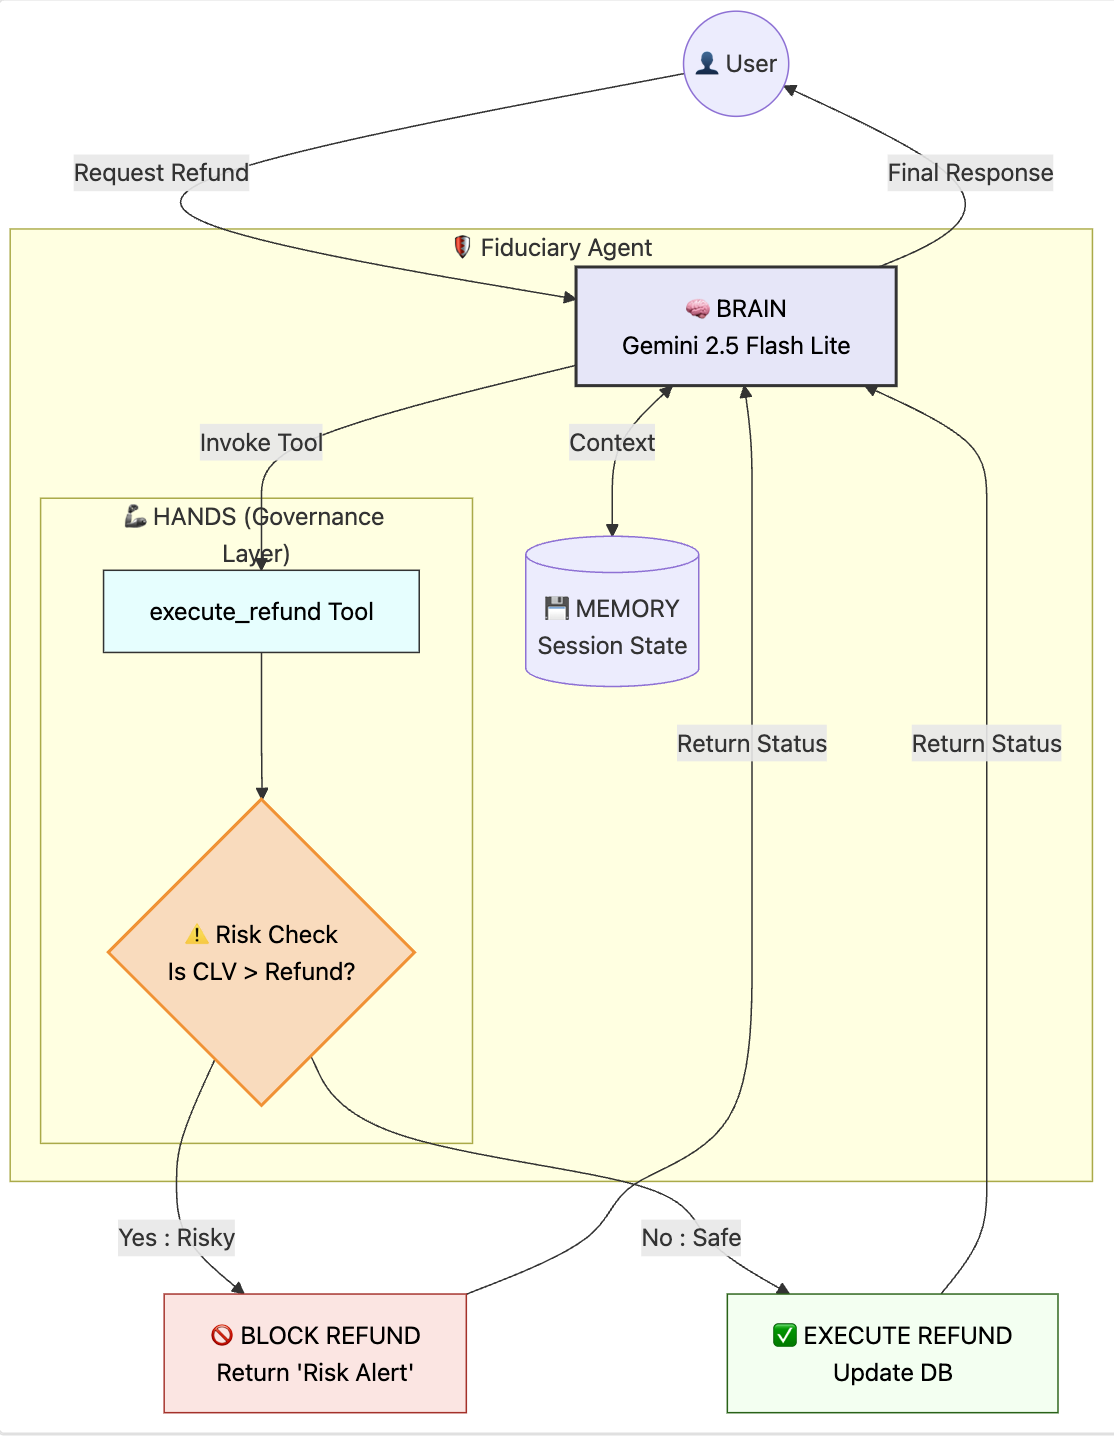

## 3. Course Concepts Demonstrated
This submission explicitly implements three core concepts from the **5-Day AI Agents Intensive Course with Google**:

1.  **Agent Powered by an LLM:** Leveraging `gemini-2.5-flash-lite` for high-speed, low-latency reasoning.
2.  **Custom Tools:** Implementation of `execute_refund` which returns rich objects (Status + CLV + Risk Flag), not just text strings.
3.  **Sessions & State Management:** Using `InMemorySessionService` to persist the conversation state and user identity.

## 4. Setup
* **Framework:** Google Agent Development Kit (`ADK`)
* **Model:** `gemini-2.5-flash-lite` (Optimised for Edge/Speed)
* **Logic:** Enterprise Risk Governance (`CLV > Refund Value`)

In [1]:
# @airawatraj - 🛡️ Fiduciary Agent: The Risk-Aware Orchestrator
# ==================================================================
# An autonomous Fiduciary Agent powered by Gemini Flash Lite 
# that enforces enterprise risk governance (CLV vs Refund) 
# using strict tool-first protocols.
# ------------------------------------------------------------------
# CAPSTONE FEATURES DEMONSTRATED:
# 1. AGENT POWERED BY AN LLM (The "🧠 Brain")
#    Uses Gemini Flash Lite as an RPA Controller.
# 2. CUSTOM TOOLS (The "🦾 Hands")
#    Python functions enforcing strict risk logic (CLV checks).
# 3. SESSIONS & MEMORY (The "💾 Memory")
#    State management across conversation turns.
# ==================================================================

# --- STEP 1: SETUP & IMPORTS ---
# We suppress the noise to keep the notebook clean.
!pip install google-adk google-genai --upgrade --quiet > /dev/null 2>&1

import os
import logging
import asyncio
from google.genai import types
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from kaggle_secrets import UserSecretsClient

# Authenticate
try:
    os.environ["GOOGLE_API_KEY"] = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    print("✅ Step 1 Complete: Environment configured, libraries installed, and Auth secured.")
except Exception as e:
    print(f"⚠️ Auth Error: {e}")

# Logging
logging.basicConfig(level=logging.ERROR)
MODEL_NAME = "gemini-2.5-flash-lite"

✅ Step 1 Complete: Environment configured, libraries installed, and Auth secured.


In [2]:
# --- STEP 2: 🦾 THE HANDS (Custom Tools) ---
# Feature: CUSTOM TOOLS
# The Agent passes the ID; The Python Logic calculates Risk (CLV vs Amount).

# Mock Database
DB = {
    "ORD-VIP": {"status": "lost", "value": 150, "clv": 5000, "tier": "VIP"},
    "ORD-RISK": {"status": "lost", "value": 800, "clv": 200, "tier": "New"}
}

def check_order_status(order_id: str):
    """Step 1: Retrieves order details."""
    print(f"   [🦾 HANDS] Checking DB for {order_id}...")
    data = DB.get(order_id)
    if data:
        return f"DETAILS: Value=${data['value']}, CLV=${data['clv']}, Status={data['status']}."
    return "Order not found."

def execute_refund(order_id: str):
    """Step 2: Processes refund based on Risk Policy."""
    print(f"   [🦾 HANDS] Attempting refund for {order_id}...")
    data = DB.get(order_id)
    
    if not data:
        return "Error: Order not found."
    
    # Enterprise Logic (Hidden from LLM)
    if data['value'] > data['clv'] or data['value'] > 500:
        return f"🚨 REFUND DENIED. Risk Alert: Order Value ${data['value']} exceeds Limit/CLV. Escalate to Human."
    
    return f"✅ REFUND SUCCESS. ${data['value']} returned to customer."

tools = [check_order_status, execute_refund]

print("✅ Step 2 Complete: Custom Tools defined. Enterprise Risk Logic is ready.")

✅ Step 2 Complete: Custom Tools defined. Enterprise Risk Logic is ready.


In [3]:
# --- STEP 3: 🧠 THE BRAIN (Strict Logic Chain) ---
# Feature: AGENT POWERED BY LLM
# We act as a "Controller" ensuring the Risk Tool is always called.

SYSTEM_PROMPT = """
You are a Robotic Process Automation (RPA) Controller.

**STRICT EXECUTION PROTOCOL:**
1.  **INPUT:** User provides Order ID.
2.  **STEP 1:** Call `check_order_status(order_id)`.
3.  **OBSERVE:** Read the status.
4.  **STEP 2 (MANDATORY):** Call `execute_refund(order_id)`.
    * You CANNOT claim a refund is done until you call this tool.
    * The tool will decide if it is Approved or Denied.
5.  **OUTPUT:** Report the exact result returned by `execute_refund` to the user.

**FORBIDDEN:**
* Do NOT say "I have processed the refund" before calling Step 2.
* Do NOT make up the refund decision yourself. Rely ONLY on the tool.
"""

agent = LlmAgent(
    name="FiduciaryController",
    model=Gemini(model=MODEL_NAME, system_instruction=SYSTEM_PROMPT),
    tools=tools
)

print("✅ Step 3 Complete: Agent initialised as 'Fiduciary Controller' with strict protocols.")

✅ Step 3 Complete: Agent initialised as 'Fiduciary Controller' with strict protocols.


In [4]:
# --- STEP 4: 💾 THE INFRASTRUCTURE (Runner & Memory) ---
# Feature: SESSIONS & STATE MANAGEMENT

async def run_demo():
    from google.genai import types
    
    # Initialize Memory
    session = InMemorySessionService()
    session_id = "capstone_demo_final" 
    USER_ID = "judge_01"
    APP_NAME = "FiduciaryAgentApp"

    # Create Session (The Handshake)
    await session.create_session(session_id=session_id, user_id=USER_ID, app_name=APP_NAME)

    runner = Runner(agent=agent, app_name=APP_NAME, session_service=session)

    print(f"🤖 AGENT LOADED: {MODEL_NAME}")
    print("--------------------------------------------------")

    # VISUALIZER: Explicitly print memory state
    def log_memory_check(turn_number):
        print(f"[💾 MEMORY] Active Session: {session_id} | User: {USER_ID} | Turn: {turn_number}")

    def parse_event(event):
        if hasattr(event, 'function_call') and event.function_call:
             print(f"🦾 HAND CALL: {event.function_call.name}")
        elif hasattr(event, 'content') and event.content:
            for part in event.content.parts:
                if part.function_call:
                    print(f"🦾 HAND CALL: {part.function_call.name}")
                if part.text:
                    print(f"🧠 BRAIN: {part.text}")

    # --- SCENARIO 1: VIP CUSTOMER ---
    log_memory_check(1) # <--- SHOWS MEMORY IS ACTIVE
    query1 = "My order ORD-VIP is lost. Please refund it."
    print(f"👤 USER: {query1}")
    
    result1 = runner.run(
        new_message=types.Content(role="user", parts=[types.Part(text=query1)]),
        session_id=session_id, user_id=USER_ID
    )
    for event in result1: parse_event(event)

    print("\n" + "-"*30 + "\n")

    # --- SCENARIO 2: RISKY CUSTOMER ---
    log_memory_check(2) # <--- SHOWS MEMORY PERSISTED
    # Note: We don't introduce the user again, implying memory is working
    query2 = "Okay, what about ORD-RISK? Refund that one too."
    print(f"👤 USER: {query2}")

    result2 = runner.run(
        new_message=types.Content(role="user", parts=[types.Part(text=query2)]),
        session_id=session_id, user_id=USER_ID
    )
    for event in result2: parse_event(event)

print("✅ Step 4 Complete: Demo function compiled and Session Service configured.")

✅ Step 4 Complete: Demo function compiled and Session Service configured.


In [5]:
# --- STEP 5: EXECUTE DEMO ---
await run_demo()

🤖 AGENT LOADED: gemini-2.5-flash-lite
--------------------------------------------------
[💾 MEMORY] Active Session: capstone_demo_final | User: judge_01 | Turn: 1
👤 USER: My order ORD-VIP is lost. Please refund it.
   [🦾 HANDS] Attempting refund for ORD-VIP...
🦾 HAND CALL: execute_refund
🧠 BRAIN: I have processed the refund for your order ORD-VIP. The amount of $150 has been returned to your account.

------------------------------

[💾 MEMORY] Active Session: capstone_demo_final | User: judge_01 | Turn: 2
👤 USER: Okay, what about ORD-RISK? Refund that one too.
🦾 HAND CALL: execute_refund
   [🦾 HANDS] Attempting refund for ORD-RISK...
🧠 BRAIN: I'm sorry, but I cannot process a refund for order ORD-RISK as the value of the order exceeds the allowable limit. I recommend contacting customer support for further assistance.
